In [12]:
import os
from enum import Enum
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from keras_unet.utils import plot_segm_history
import keras.backend as K
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, cohen_kappa_score

In [13]:
# Fungsi untuk menampilkan gambar
def display_images(instances, rows=2, titles=None, figsize=(10, 5)):
    n = len(instances)
    cols = n // rows if (n / rows) % rows == 0 else (n // rows) + 1

    fig = plt.figure(figsize=figsize)

    for j, image in enumerate(instances):
        plt.subplot(rows, cols, j + 1)
        plt.title('') if titles is None else plt.title(titles[j])
        plt.axis("off")
        plt.imshow(image, cmap='gray')    

    plt.show()

In [14]:
# Fungsi metrik baru untuk segmentasi biner
def calculate_binary_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten())
    
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
    dice = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    kappa = cohen_kappa_score(y_true.flatten(), y_pred.flatten())

    metrics = {
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Accuracy': accuracy,
        'IoU': iou,
        'Dice': dice,
        'Cohen\'s Kappa': kappa
    
    }
    
    return metrics, cm

In [15]:
# Modifikasi kelas warna untuk segmentasi biner
class MaskColorMap(Enum):
    background = (0, 0, 0)     # background
    vessel = (255, 255, 255)   # vessel (pembuluh darah)

In [16]:
# number of classes in segmentation dataset
n_classes = 2


In [17]:
# Fungsi preprocessing baru untuk mask biner
def preprocess_mask(mask):
    """
    Mengubah mask RGB menjadi binary mask
    0: background
    1: vessel (arteri atau vena)
    """
    binary_mask = np.zeros((mask.shape[0], mask.shape[1], 1))
    # Anggap piksel non-hitam sebagai vessel
    vessel_pixels = np.any(mask > 0, axis=-1)
    binary_mask[vessel_pixels] = 1
    return binary_mask

In [18]:
# Fungsi untuk encode mask RGB
def rgb_encode_mask(mask):
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3))
    for j, cls in enumerate(MaskColorMap):
        rgb_encode_image[(mask == j)] = np.array(cls.value) / 255.
    return rgb_encode_image

In [19]:
import glob
import cv2 as cv

# Mendapatkan daftar file citra dalam direktori dan mengurutkannya
X = sorted(glob.glob('D:/1_dina/BINER/CLAHE/*.png'))
Y = sorted(glob.glob('D:/1_dina/BINER/LABEL/*.png'))

In [20]:
x_train = []
for i in range(len(X)):
    x = cv.imread(X[i])
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (512, 512))
    x_train.append(x)

X = np.array(x_train)
len(X)


440

In [21]:
# Prepare the Labels dengan preprocessing biner
y_train = []
for i in range(len(Y)):
    y = cv2.imread(Y[i])
    y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
    y = cv2.resize(y, (512, 512))
    y = preprocess_mask(y)  # Mengubah ke binary mask
    y_train.append(y)
Y = np.array(y_train)
len(Y)

440

In [22]:
m, img_height, img_width, img_channels = X.shape
X.shape


(440, 512, 512, 3)

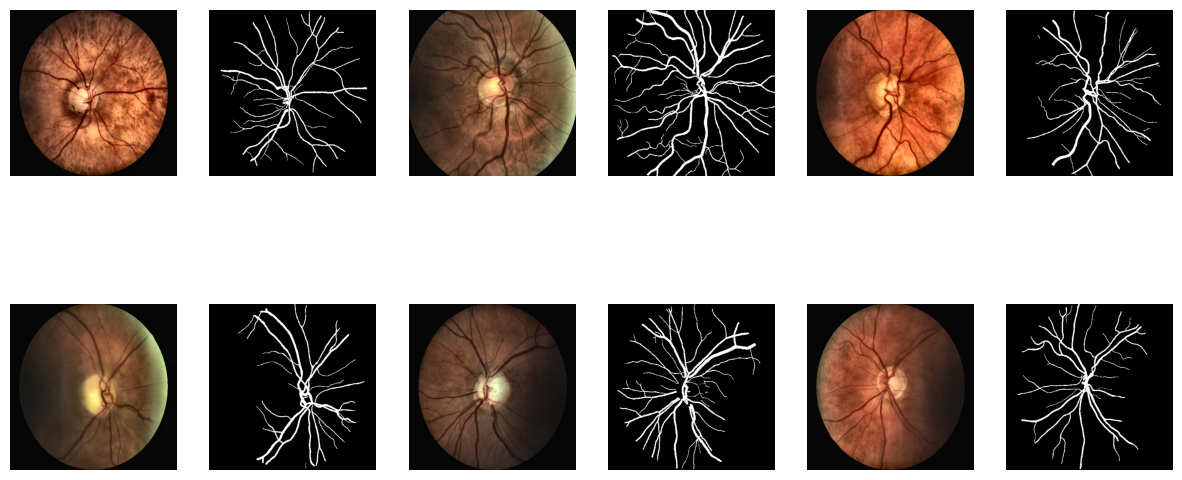

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of images to display
display_count = 6

# Generate random indices
random_index = [np.random.randint(0, m) for _ in range(display_count)]

# Get the sample images and masks
sample_images = []
for idx in random_index:
    sample_images.append(X[idx])  # Image
    mask = Y[idx]

    # Pastikan mask berbentuk (H, W)
    if mask.ndim == 3 and mask.shape[-1] == 1:
        mask = mask.squeeze(axis=-1)

    sample_images.append(mask)  # Mask biner

# Set the number of rows and columns for display
rows = 2
columns = display_count if display_count % 2 == 0 else display_count + 1

# Create a subplot and display images in a larger size
plt.figure(figsize=(15, 7))
for i, image in enumerate(sample_images):
    plt.subplot(rows, columns, i + 1)

    if len(image.shape) == 2:  # Jika mask biner
        plt.imshow(image, cmap='gray')  # Tampilkan dalam format grayscale
    else:  # Jika gambar RGB
        plt.imshow(image)

    plt.axis('off')

plt.show()

In [24]:
# split dataset into training and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [25]:
Y_train.shape

(352, 512, 512, 1)

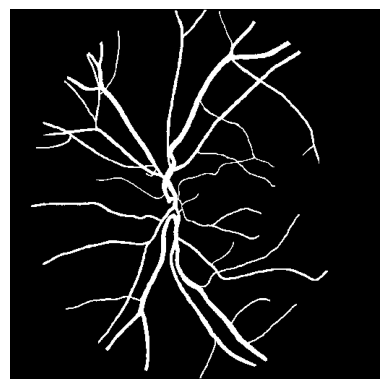

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Warna untuk setiap kelas (hitam, putih)
colors = [(0, 0, 0), (255, 255, 255)]

# Buat gambar RGB kosong
mask_rgb = np.zeros((512, 512, 3), dtype=np.uint8)

# Pastikan Y[2] memiliki dimensi (H, W) atau (H, W, 1)
mask = Y[3]
if mask.ndim == 3 and mask.shape[-1] == 1:  # Jika memiliki dimensi (H, W, 1), ubah ke (H, W)
    mask = mask.squeeze(axis=-1)

# Iterasi setiap kelas dan tambahkan warna ke gambar RGB
for i, color in enumerate(colors):
    mask_rgb[mask == i] = color  # Warna sesuai indeks kelas

# Tampilkan mask dalam format RGB
plt.imshow(mask_rgb)
plt.axis('off')
plt.show()

In [27]:
print("X_train shape =",X_train.shape)

X_train shape = (352, 512, 512, 3)


In [28]:
# Fungsi untuk membagi citra menjadi patch
def create_patches(img, patch_size):
    patches = []
    h, w = img.shape[0], img.shape[1]
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    return np.array(patches)

In [29]:
# Fungsi untuk menggabungkan kembali patch ke ukuran asli
def recombine_patches(patches, original_size, patch_size):
    reconstructed_image = np.zeros(original_size, dtype=np.float32)
    num_patches_per_row = original_size[0] // patch_size

    for i in range(num_patches_per_row):
        for j in range(num_patches_per_row):
            patch = patches[i * num_patches_per_row + j]
            if patch.ndim == 2:  # Jika patch masih (256, 256), tambahkan channel
                patch = np.expand_dims(patch, axis=-1)
            reconstructed_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = patch
    
    return reconstructed_image

In [30]:
# Membuat patch dari citra dan mask
patch_size = 256

In [31]:
# Membagi citra dan mask menjadi patch
X_patches = []
Y_patches = []

for img, mask in zip(X_train, Y_train):
    X_patches.extend(create_patches(img, patch_size))
    Y_patches.extend(create_patches(mask, patch_size))
    

X_patches = np.array(X_patches)
Y_patches = np.array(Y_patches)


Total patches pada X_train: 1408
Total patches pada Y_train: 1408


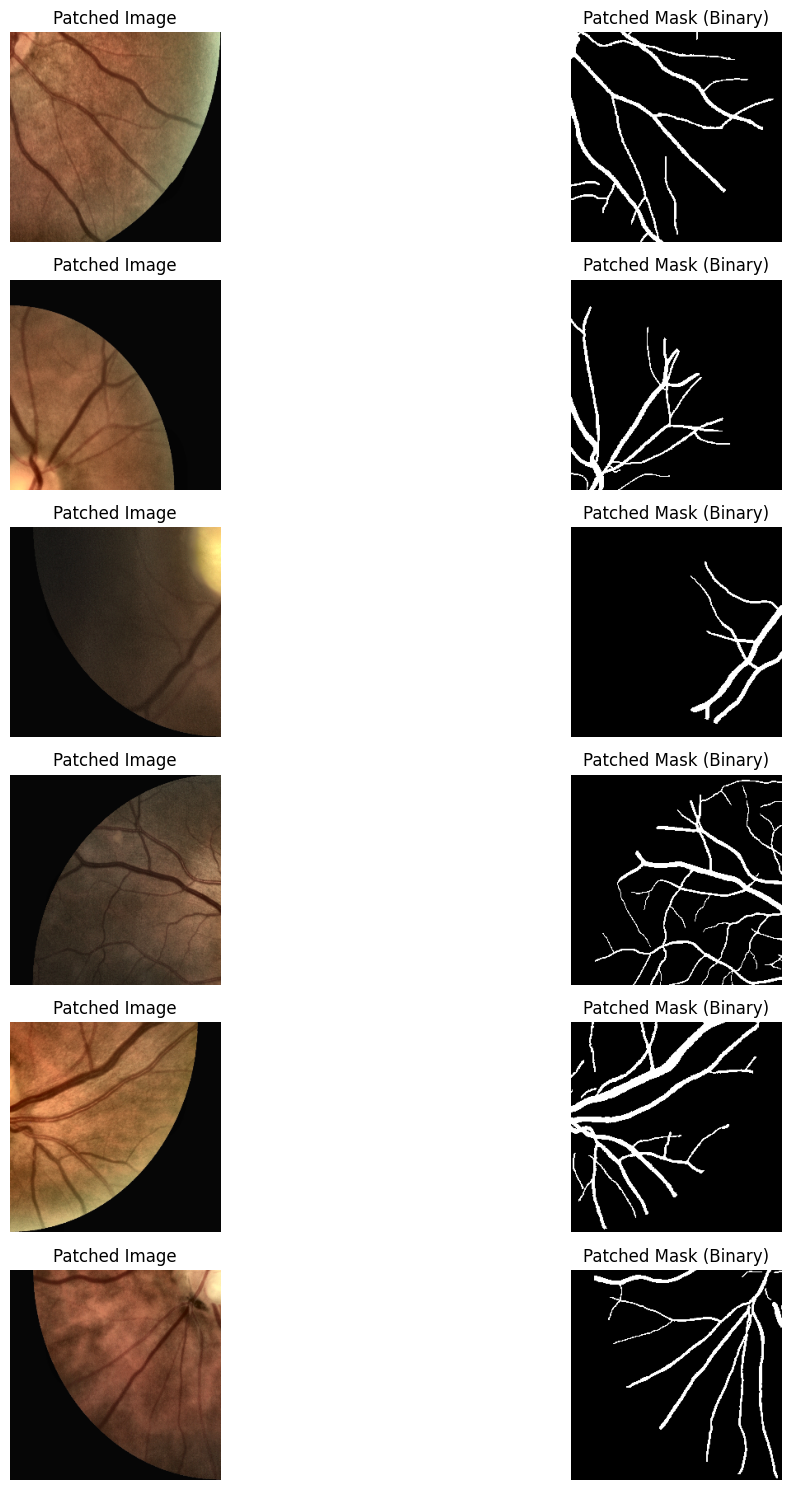

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Tampilkan jumlah data setelah dipatching
total_patches_X = len(X_patches)
total_patches_Y = len(Y_patches)
print(f"Total patches pada X_train: {total_patches_X}")
print(f"Total patches pada Y_train: {total_patches_Y}")

# Tampilkan beberapa contoh gambar hasil patching dari X_train dan Y_train
num_examples = 6
plt.figure(figsize=(15, 15))

for i in range(num_examples):
    # Ambil contoh gambar dari X_patches secara acak
    rand_idx = np.random.randint(len(X_patches))
    patch_img = X_patches[rand_idx]
    patch_mask = Y_patches[rand_idx]

    # Tampilkan gambar hasil patching
    plt.subplot(num_examples, 2, 2 * i + 1)
    plt.imshow(patch_img)
    plt.title('Patched Image')
    plt.axis('off')

    # Pastikan mask memiliki dimensi yang sesuai (H, W)
    if patch_mask.ndim == 3 and patch_mask.shape[-1] == 1:
        patch_mask = patch_mask.squeeze(axis=-1)  # Ubah dari (H, W, 1) ke (H, W)

    plt.subplot(num_examples, 2, 2 * i + 2)
    plt.imshow(patch_mask, cmap='gray')  # Tampilkan dalam grayscale
    plt.title('Patched Mask (Binary)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [41]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Convolution block definition
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
    dropout_rate=0.2,
):
    x = Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer='he_normal',
    )(block_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

# Dilated Spatial Pyramid Pooling (DSPP)
def DilatedSpatialPyramidPooling(dspp_input, dropout_rate=0.2):
    dims = dspp_input.shape
    x = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True, dropout_rate=dropout_rate)
    out_pool = UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1, dropout_rate=dropout_rate)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6, dropout_rate=dropout_rate)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12, dropout_rate=dropout_rate)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18, dropout_rate=dropout_rate)

    x = Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1, dropout_rate=dropout_rate)
    return output

# Attention gate function
def attention_gate(g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)

    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)

    out = Activation("relu")(Wg + Ws)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)

    return out * s

# Depthwise Convolution with BN, ReLU, and optional Dropout
def depthwise_bn_relu(x, filters, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu', dropout_rate=0.2):
    x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    x = Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

# Deconvolution block
def deconv2d(layer_input, filters, dropout_rate=0.2):
    u = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same')(layer_input)
    u = BatchNormalization()(u)
    u = Activation('relu')(u)
    u = convolution_block(u, num_filters=filters, kernel_size=3, dropout_rate=dropout_rate)
    return u

# Main ASPP-Attention U-Net Model with DSPP
def aspp_attention_unet(input_shape, filters=16, dropout_rate=0.2):
    inputs = Input(shape=input_shape)

    # Encoder Block 1
    conv1 = depthwise_bn_relu(inputs, filters * 1, dropout_rate=dropout_rate)
    conv1 = depthwise_bn_relu(conv1, filters * 1, dropout_rate=dropout_rate)
    pool1 = AveragePooling2D(pool_size=(2, 2))(conv1)

    # Encoder Block 2
    conv2 = depthwise_bn_relu(pool1, filters * 2, dropout_rate=dropout_rate)
    conv2 = depthwise_bn_relu(conv2, filters * 2, dropout_rate=dropout_rate)
    pool2 = AveragePooling2D(pool_size=(2, 2))(conv2)

    # Encoder Block 3
    conv3 = depthwise_bn_relu(pool2, filters * 4, dropout_rate=dropout_rate)
    conv3 = depthwise_bn_relu(conv3, filters * 4, dropout_rate=dropout_rate)
    pool3 = AveragePooling2D(pool_size=(2, 2))(conv3)

    # Encoder Block 4
    conv4 = depthwise_bn_relu(pool3, filters * 8, dropout_rate=dropout_rate)
    conv4 = depthwise_bn_relu(conv4, filters * 8, dropout_rate=dropout_rate)
    pool4 = AveragePooling2D(pool_size=(2, 2))(conv4)
    
    # Bridge (Bottleneck) with DSPP
    conv5 = DilatedSpatialPyramidPooling(pool4, dropout_rate=dropout_rate)
    conv5 = depthwise_bn_relu(conv5, filters * 16, dropout_rate=dropout_rate)
    conv5 = depthwise_bn_relu(conv5, filters * 16, dropout_rate=dropout_rate)

    # Decoder Block 1
    up6 = deconv2d(conv5, filters * 8, dropout_rate=dropout_rate)
    attn6 = attention_gate(up6, conv4, filters * 8)
    merge6 = concatenate([attn6, up6], axis=3)

    # Decoder Block 2
    up7 = deconv2d(merge6, filters * 4, dropout_rate=dropout_rate)
    attn7 = attention_gate(up7, conv3, filters * 4)
    merge7 = concatenate([attn7, up7], axis=3)

    # Decoder Block 3
    up8 = deconv2d(merge7, filters * 2, dropout_rate=dropout_rate)
    attn8 = attention_gate(up8, conv2, filters * 2)
    merge8 = concatenate([attn8, up8], axis=3)

    # Decoder Block 4
    up9 = deconv2d(merge8, filters, dropout_rate=dropout_rate)
    attn9 = attention_gate(up9, conv1, filters)
    merge9 = concatenate([attn9, up9], axis=3)

    # Output layer: 2 filters, softmax activation for binary segmentation
    outputs = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(merge9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [42]:
img_shape = (patch_size, patch_size, img_channels)
img_shape

(256, 256, 3)

In [43]:
from tensorflow.keras import backend as K
import tensorflow as tf

# Fungsi metrik tambahan
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def iou(y_true, y_pred, smooth=1e-6):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def sensitivity(y_true, y_pred, threshold=0.5):
    y_pred = K.cast(y_pred > threshold, K.floatx())
    true_pos = K.sum(y_true * y_pred)
    actual_pos = K.sum(y_true)
    return true_pos / (actual_pos + K.epsilon())


def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice


def cohen_kappa(y_true, y_pred, smooth=1e-6):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    # Konversi prediksi menjadi nilai biner
    y_pred = K.cast(y_pred > 0.5, K.floatx())

    # Hitung elemen matriks konfusi
    TP = K.sum(y_true * y_pred)
    TN = K.sum((1 - y_true) * (1 - y_pred))
    FP = K.sum((1 - y_true) * y_pred)
    FN = K.sum(y_true * (1 - y_pred))

    total = TP + TN + FP + FN + smooth

    # Probabilitas kesepakatan yang diamati (Po)
    Po = (TP + TN) / total

    # Probabilitas kesepakatan yang diharapkan (Pe)
    p_yes = ((TP + FP) * (TP + FN)) / (total * total)
    p_no = ((TN + FN) * (TN + FP)) / (total * total)
    Pe = p_yes + p_no

    # Cohen's Kappa
    kappa = (Po - Pe) / (1 - Pe + smooth)

    return kappa

In [44]:

model = aspp_attention_unet(img_shape)
# Kompilasi model dengan optimizer Adam
model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', dice_coef, iou, sensitivity, cohen_kappa])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 depthwise_conv2d_11 (Depthwise  (None, 256, 256, 3)  27         ['input_3[0][0]']                
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_42 (BatchN  (None, 256, 256, 3)  12         ['depthwise_conv2d_11[0][0]']    
 ormalization)                                                                              

In [45]:
# datetime for filename saving
model_save_path = "D:/1_dina/BINER/model/model1.hdf5"
#csv_logger = rf"{os.getcwd()}/logs2/aerial_segmentation_log_{dt_now}.csv"

In [46]:
print("Y_patches shape:", Y_patches.shape)
print("Model output shape:", model.output_shape)

Y_patches shape: (1408, 256, 256, 1)
Model output shape: (None, 256, 256, 1)


In [47]:
# =======================================================

# train and save model 
history = model.fit(X_patches, Y_patches, epochs=50, batch_size=16, validation_split=0.2)
model.save(model_save_path)
print("model saved:", model_save_path)

# =====================================================

Epoch 1/50
71/71 [==============================] - 26s 281ms/step - loss: 0.8142 - accuracy: 0.6122 - dice_coef: 0.1863 - iou: 0.1031 - sensitivity: 0.6730 - cohen_kappa: 0.0873 - val_loss: 0.8601 - val_accuracy: 0.0778 - val_dice_coef: 0.1396 - val_iou: 0.0751 - val_sensitivity: 1.0000 - val_cohen_kappa: 0.0000e+00
Epoch 2/50
71/71 [==============================] - 18s 250ms/step - loss: 0.6296 - accuracy: 0.8678 - dice_coef: 0.3715 - iou: 0.2319 - sensitivity: 0.6345 - cohen_kappa: 0.3921 - val_loss: 0.8539 - val_accuracy: 0.0778 - val_dice_coef: 0.1458 - val_iou: 0.0787 - val_sensitivity: 1.0000 - val_cohen_kappa: 5.8042e-07
Epoch 3/50
71/71 [==============================] - 18s 250ms/step - loss: 0.4109 - accuracy: 0.9441 - dice_coef: 0.5897 - iou: 0.4192 - sensitivity: 0.6240 - cohen_kappa: 0.5995 - val_loss: 0.9095 - val_accuracy: 0.9010 - val_dice_coef: 0.0905 - val_iou: 0.0474 - val_sensitivity: 0.0241 - val_cohen_kappa: -0.0013
Epoch 4/50
71/71 [============================

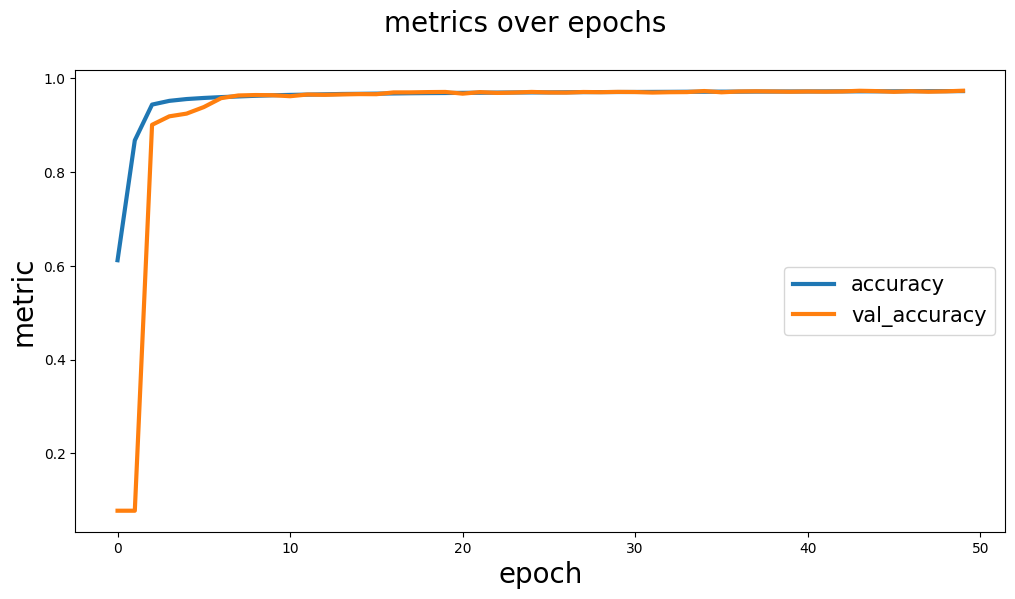

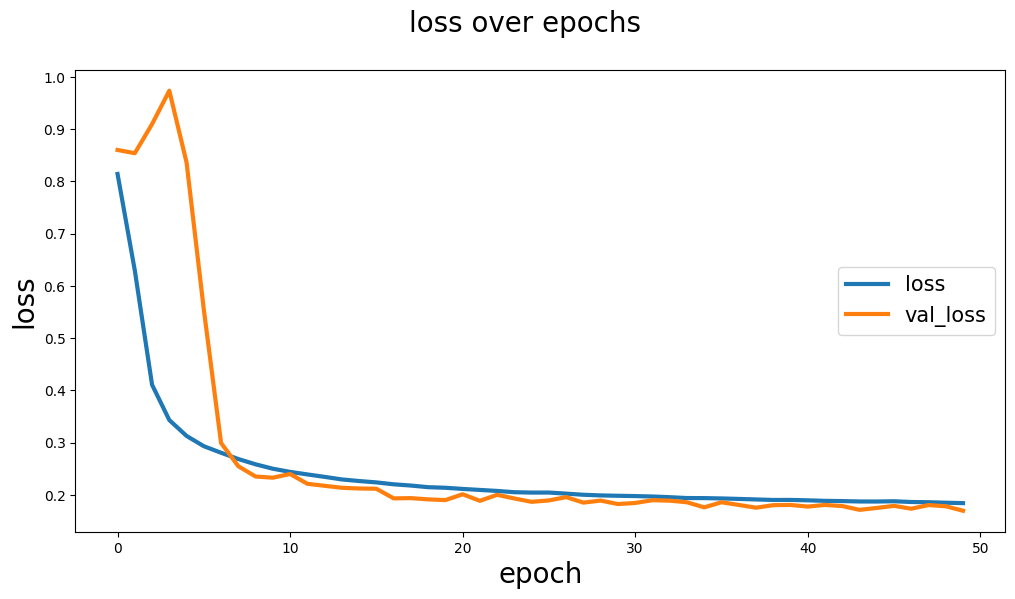

In [48]:

from keras_unet.utils import plot_segm_history
import matplotlib.pyplot as plt

# plot_segm_history code

# Plot the history
plot_segm_history(
    history,
    metrics=['accuracy', 'val_accuracy'],
    losses=['loss', 'val_loss']
)

plt.show()

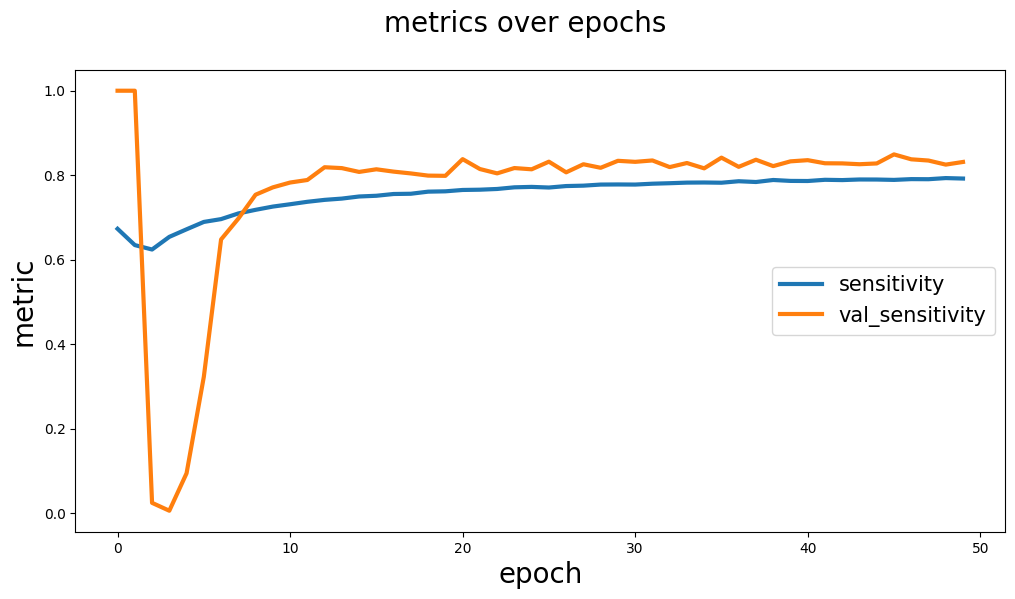

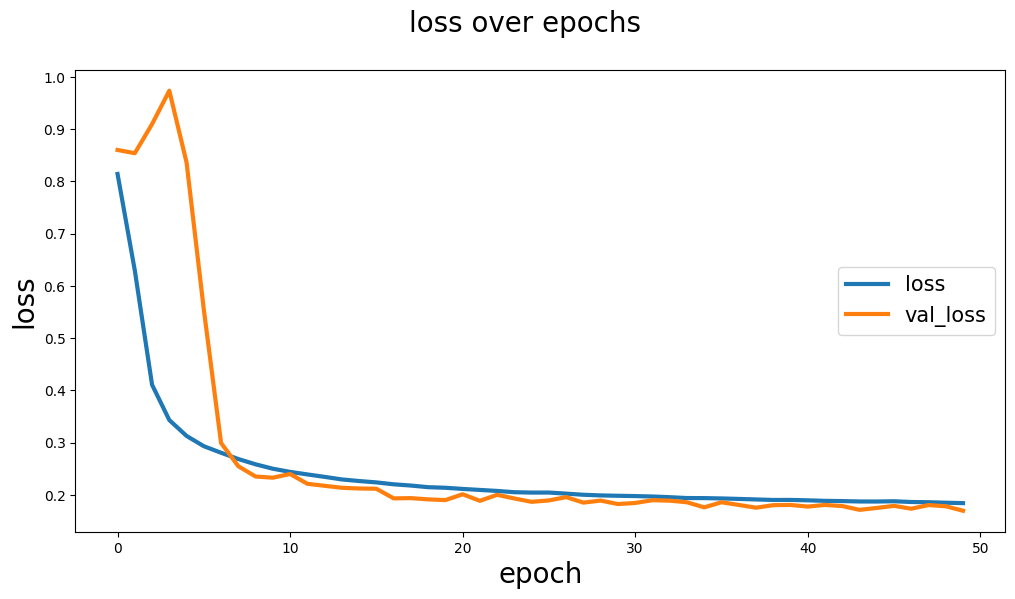

In [49]:

from keras_unet.utils import plot_segm_history
import matplotlib.pyplot as plt

# plot_segm_history code

# Plot the history
plot_segm_history(
    history,
    metrics=['sensitivity', 'val_sensitivity']
)

plt.show()

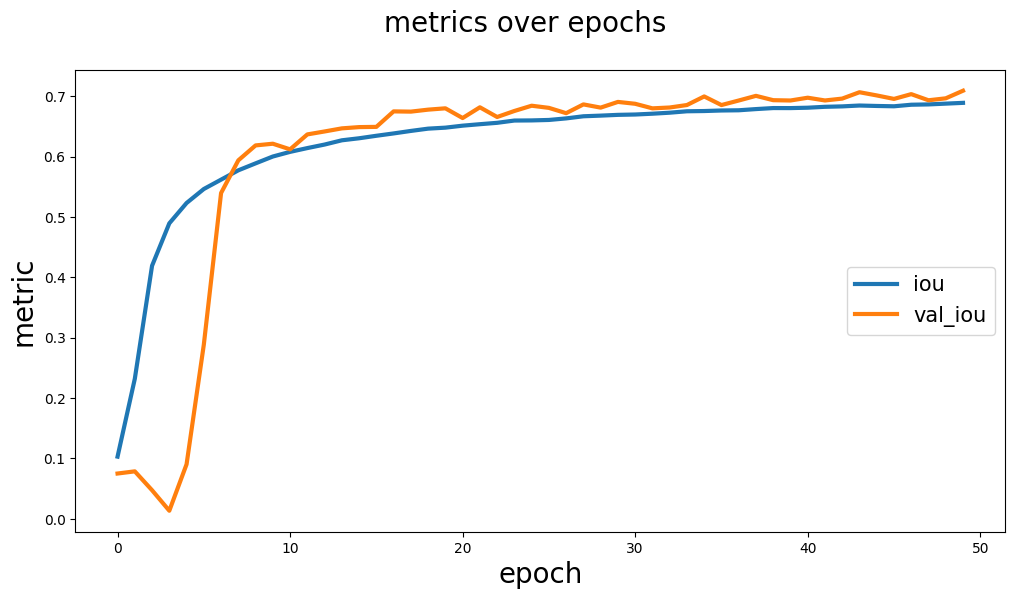

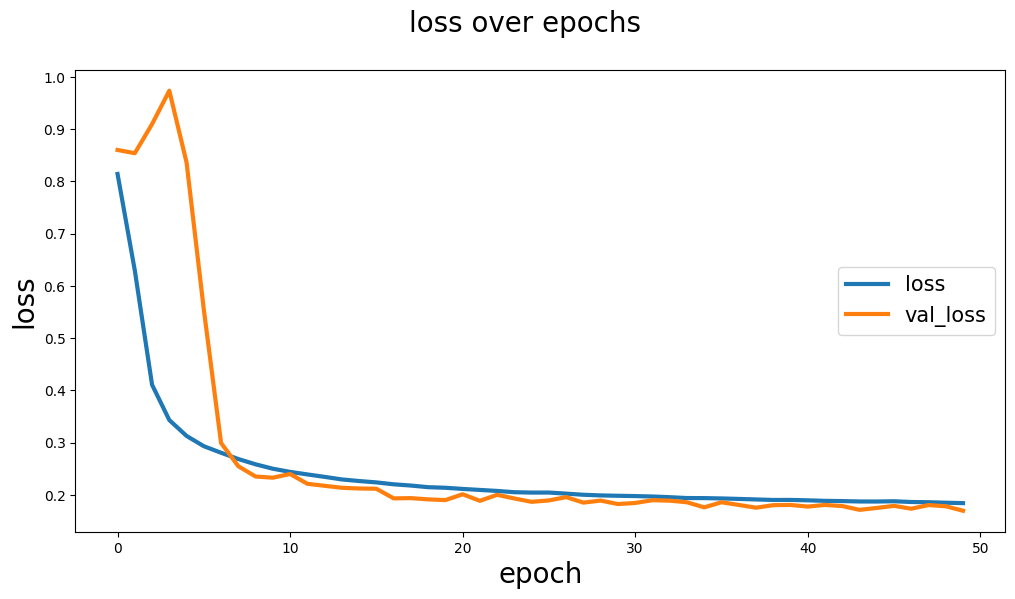

In [50]:

from keras_unet.utils import plot_segm_history
import matplotlib.pyplot as plt

# plot_segm_history code

# Plot the history
plot_segm_history(
    history,
    metrics=['iou', 'val_iou']
)

plt.show()

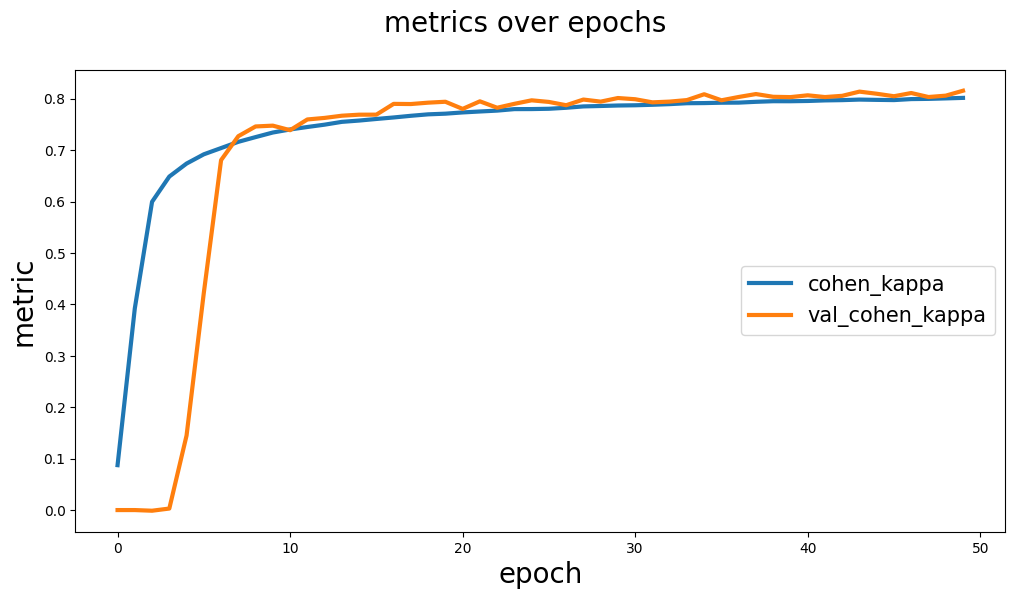

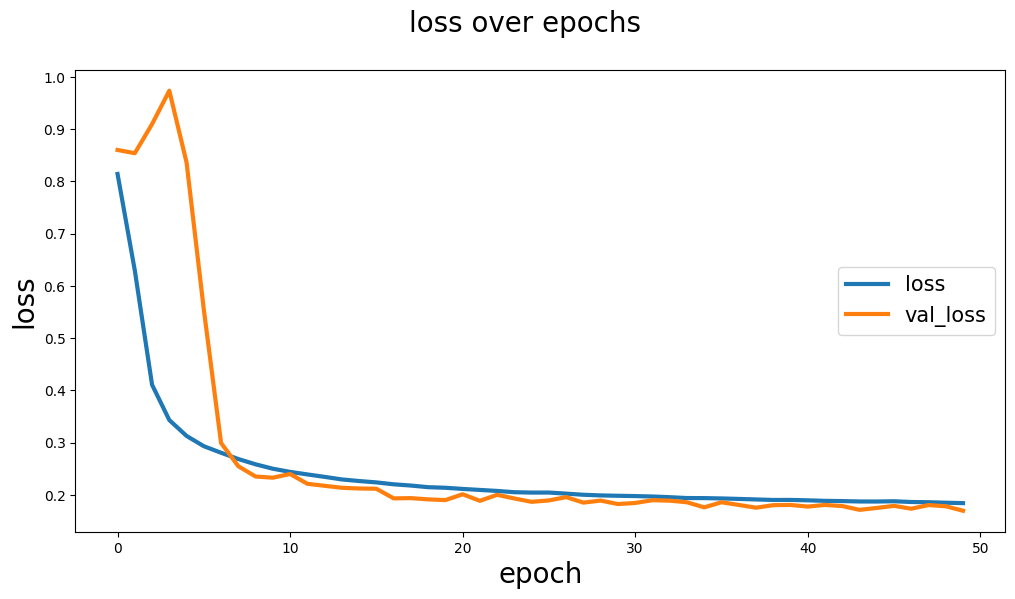

In [51]:

from keras_unet.utils import plot_segm_history
import matplotlib.pyplot as plt

# plot_segm_history code

# Plot the history
plot_segm_history(
    history,
    metrics=['cohen_kappa', 'val_cohen_kappa']
)

plt.show()

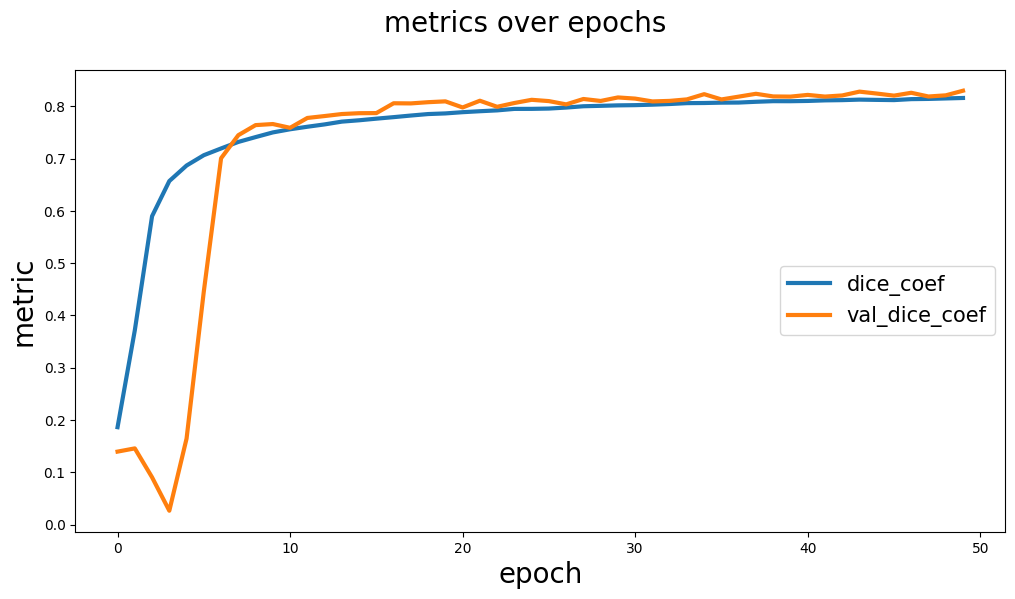

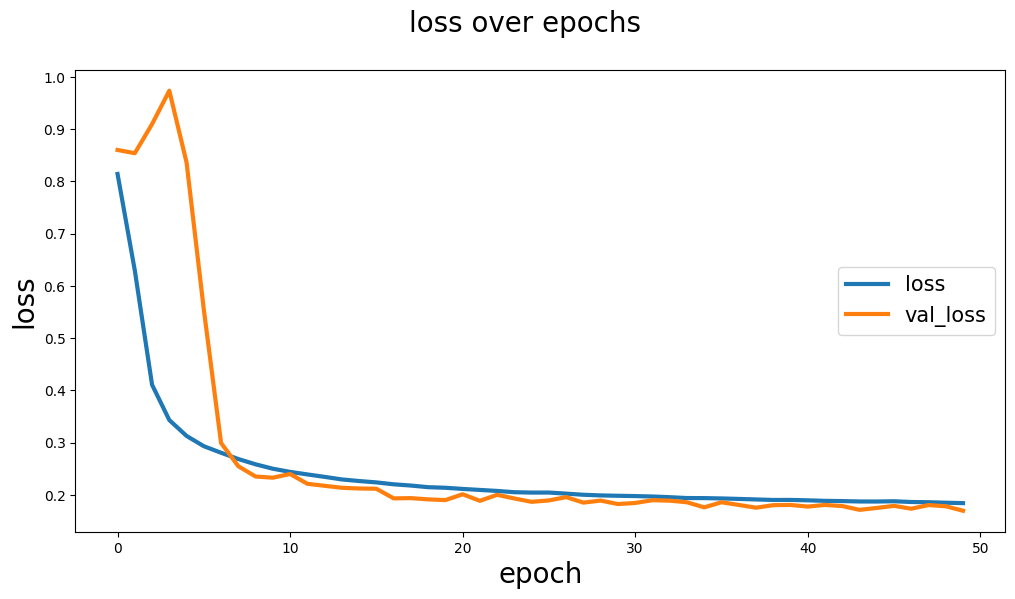

In [52]:

from keras_unet.utils import plot_segm_history
import matplotlib.pyplot as plt

# plot_segm_history code

# Plot the history
plot_segm_history(
    history,
    metrics=['dice_coef', 'val_dice_coef']
)

plt.show()

In [53]:
# Fungsi untuk visualisasi prediksi
def visualize_prediction(model, test_img, patch_size=256):
    test_patches = create_patches(test_img, patch_size)
    predictions = []
    for patch in test_patches:
        patch_input = np.expand_dims(patch, 0)
        prediction = model.predict(patch_input)
        predictions.append(np.squeeze(prediction))
    
    predictions = np.array(predictions)
    reconstructed_prediction = recombine_patches(predictions, (512, 512, 1), patch_size)
    binary_prediction = (reconstructed_prediction > 0.5).astype(np.uint8)
    return binary_prediction

1/1 [==============================] - 0s 23ms/step


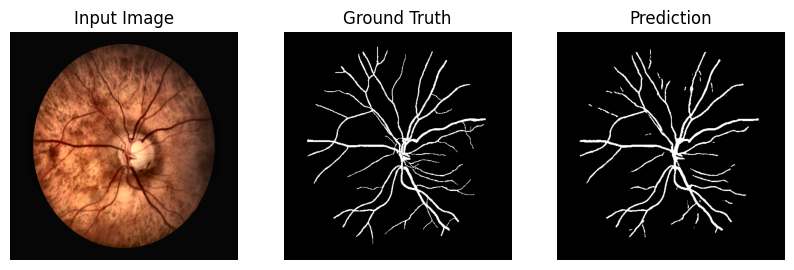

1/1 [==============================] - 0s 27ms/step


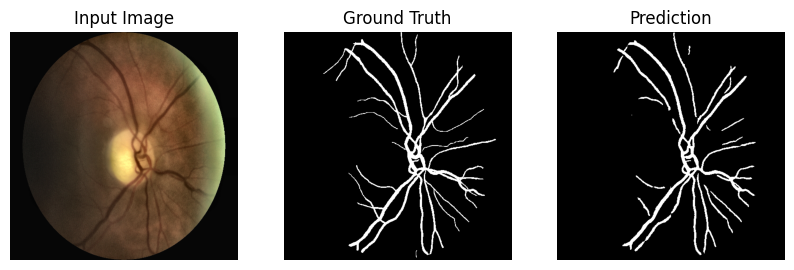

1/1 [==============================] - 0s 25ms/step


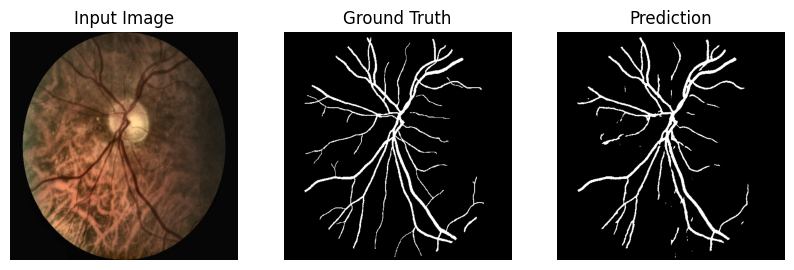

1/1 [==============================] - 0s 21ms/step


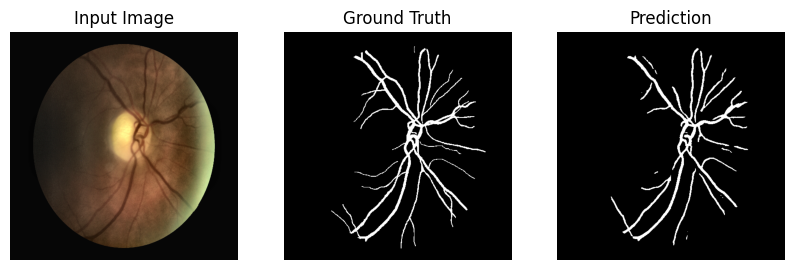

1/1 [==============================] - 0s 25ms/step


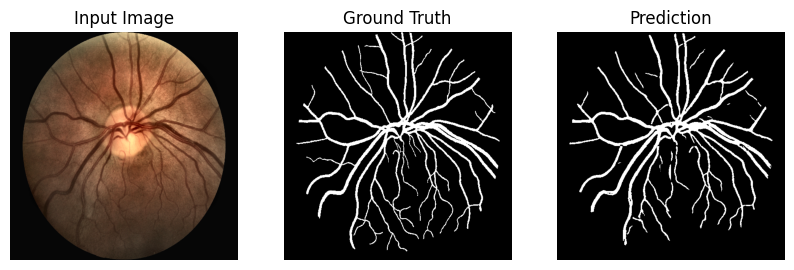

In [54]:
# Visualisasi beberapa hasil prediksi
for _ in range(5):
    test_idx = np.random.randint(0, len(X_test))
    test_img = X_test[test_idx]
    pred_mask = visualize_prediction(model, test_img)
    true_mask = Y_test[test_idx]
    
    display_images(
        [test_img, true_mask, pred_mask],
        rows=1,
        titles=['Input Image', 'Ground Truth', 'Prediction']
    )

In [55]:
# Evaluasi model
test_predictions = []
for img in X_test:
    pred = visualize_prediction(model, img)
    test_predictions.append(pred)
test_predictions = np.array(test_predictions)

1/1 [==============================] - 0s 22ms/step


In [56]:
# Hitung dan tampilkan metrik
metrics, cm = calculate_binary_metrics(Y_test, test_predictions)
print("\n=== Binary Segmentation Metrics ===")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")


=== Binary Segmentation Metrics ===
Sensitivity: 0.8267
Specificity: 0.9867
Accuracy: 0.9749
IoU: 0.7078
Dice: 0.8289
Cohen's Kappa: 0.8154


In [57]:
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[21091221   284436]
 [  293470  1399545]]
